# Angel Moreno - Fashion-MNIST Project

### Introduction

In this notebook, I will be working with the fashion-mnist dataset containing 60,000 28x28 greyscale images. These images fall inside 1 of 10 labels, ranging from ankle boots to t-shirts. In this project I will be running both supervised and unsupervised models. I will use a multi-class logistic regression model, Principle Component Analysis (PCA) model, 2 models from the Scikit-Learn package, and finally a model from the cuML package (which requires GPU).

### Load Data

First, I import the appropriate packages which I'll be using for the rest of the notebook. When using pandas to load the data, I include a sample of 5 samples to get a visual of what the data looks like in a DataFrame. 

Now, there's no need to split the data because the training and test data are already separated into two .csv files. However, in order to construct the models I'll need to have the data in ndarray form. For that reason, I transform the data into matrices X_train and X_test while ignoring the first column as those values are the labels. I also transform the labels into vector form y_train and y_test by only including the first column in the datasets. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
fashion_train = pd.read_csv('fashion-mnist_train.csv')
fashion_test = pd.read_csv('fashion-mnist_test.csv')

In [3]:
fashion_test.sample(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
5507,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7628,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4236,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7898,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9114,4,0,0,0,0,0,0,0,0,0,...,0,0,0,161,205,200,123,0,0,0


Below are the shapes of our data matrices:

In [4]:
X_train = pd.DataFrame.to_numpy(fashion_train.iloc[:,1:])
X_train.shape

(60000, 784)

In [5]:
y_train = pd.DataFrame.to_numpy(fashion_train['label'])
y_train.shape

(60000,)

In [6]:
X_test = pd.DataFrame.to_numpy(fashion_test.iloc[:,1:])
X_test.shape

(10000, 784)

In [7]:
y_test = pd.DataFrame.to_numpy(fashion_test['label'])
y_test.shape

(10000,)

### Logistic Regression

Now we begin our first model. Since there are 10 labels in our dataset, this will be a multi-class logistic regression model. First, we elementwise divide our matrix $XW$ by 1000 in the sigma method in order to avoid nan errors. Without this modification, our softmax function would fail because $e^{z_i}$ would be too large of a number for our computer to handle. Second, we let our initial weights matrix $W$ be a matrix of ones rather than zeros to avoid dividing by 0 in the sigma function. Finally, the learning rate is smaller by a factor of $10^{-2}$. This is because the previous learning rate of .1 was too large for our gradient descent (GD) algorithm and as a result our loss function was not converging.

After training, this supervised learning model will be able to effectively predict which of the 10 labels belongs to a new image.

In [8]:
import tqdm.notebook

In [26]:
class myLogisticRegression():
    """ Logistic Regression classifier -- this also works for the multiclass case.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    """
    def __init__(self, learning_rate=.1):
        
        
        self.learning_rate = learning_rate
        

    def fit(self, data, y, n_iterations = 1000):
        """ This method finds the optimal weights to be used in the model's linear combination computations.
        Parameters: 
        -----------
        data: ndarray
        This should be taken from the DataFrame being studied. This is specifically the training data.
        y: ndarray
        This should also be taken from the DataFrame being studied. This is specifically the labels corresponding 
        to the training data.
        N_iterations: int 
        represents the the amount of times the model will run the gradient descent (GD)
        algorithm to minimize the loss function. The default is 1000 iterations.
        """
        self.K = max(y)+1 # specify number of classes in y
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        eta = self.learning_rate
        
        W  = np.ones((np.shape(X)[1],max(y)+1)) # I use np.ones rather than np.zeros to avoid dividing by 0 later on.
                                                #However, any other values can be selected for the elements of W.

        for k in range(n_iterations):
            dW = self.loss_gradient(W,X,y) # write another function to compute gradient
            W = W - eta * dW # the formula of GD
            # this step is optional -- just for inspection purposes
            #if k % 500 == 0: # print loss every 500 steps
            print("loss after", k+1, "iterations is: ", self.loss(W,X,y))
        
        self.coeff = W
        
    def predict(self, data):
        '''After the training is finished and the optimal weights are found, this method takes as input new data and 
        predicts the label that belongs to it.
        Parameters:
        -----------
        data: ndarray
        This should be taken from the DataFrame being studied. This is specifically the test data or any other
        data not previously used for training.'''
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        W = self.coeff # the estimated W
        y_pred = np.argmax(self.sigma(X,W), axis =1) # the category with largest probability
        return y_pred
    
    def score(self, data, y_true):
        '''After the training is finished and the optimal weights are found, this method reports the accuracy of this 
        model. It will return a value between 0 and 1 which is the proportion of data samples that were labeled correctly.
        Parameters:
        -----------
        data: ndarray
        This should be taken from the DataFrame being studied. This is specifically test data because it requires that 
        the correct labels are also available.
        y_true: ndarray
        This should be taken from the DataFrame being studied. This is specifically the true labels that belong to the 
        test data.'''
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc
    
    def sigma(self,X,W):
        '''This is the softmax function. After the 'probabilities' are outputed for each label, this method chooses the 
        label with the highest probability. These values are also exponentiated to emphasize the largest values distance 
        from the other values.
        Parameters:
        -----------
        W: ndarray
        This matrix is the orginal input of weights used for our linear combination. This matrix can contain any values 
        as they will change after every iteration of the algorithm.
        X: ndarray
        This matrix contains the features of each data sample. However, it is augmented by concatenating a column of ones 
        as the new first column.'''
        s = np.exp(np.matmul(X,W)/(1000))   #Divide by 1000 here in order to avoid getting values that the computer can't handle.
        total = np.sum(s, axis=1).reshape(-1,1)
        return s/total
    
    def loss(self,W,X,y):
        '''This method takes the output of the linear combinations as input and outputs a value between 0 and 1 to be 
        understood as a 'probability' that the data sample belongs to a specific label. There is a loss function for each
        possible label. The goal is to maximize the 'probability' that the data sample is correctly labeled.
        Parameters:
        -----------
        W: ndarray
        This matrix is the orginal input of weights used for our linear combination. This matrix can contain any values 
        as they will change after every iteration of the algorithm.
        X: ndarray
        This matrix contains the features of each data sample. However, it is augmented by concatenating a column of ones 
        as the new first column.'''
        f_value = self.sigma(X,W)
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) # avoid nan issues
        return -np.mean(loss_vector)
                          
    def loss_gradient(self,W,X,y):
        '''This method is used to minimize our loss function through an algorithm. Any set of weights can be inputed 
        and the method will take the negative gradient of the loss function multiplied by a small factor and select new
        weights until the loss function converges to a minimum.
        Parameters:
        -----------
        W: ndarray
        This matrix is the orginal input of weights used for our linear combination. This matrix can contain any values 
        as they will change after every iteration of the algorithm.
        X: ndarray
        This matrix contains the features of each data sample. However, it is augmented by concatenating a column of ones 
        as the new first column.'''
        f_value = self.sigma(X,W)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X # Numpy broadcasting
            dLdW[:,k] = np.mean(dLdWk, axis=0)   # RHS is 1D Numpy array -- so you can safely put it in the k-th column of 2D array dLdW
        return dLdW

We initialize in instance of the class:

In [10]:
fashionlog = myLogisticRegression(learning_rate = 1e-3) #We lower the learning rate to make GD functional

We train the model on our training dataset of 60,000 images. This takes quite some time for the computer to do as we set the number of iterations to 1200. 

In [12]:
%%time
fashionlog.fit(X_train,y_train,n_iterations = 1200)

loss after 1 iterations is:  2.146623169014448
loss after 2 iterations is:  2.031458323473775
loss after 3 iterations is:  1.9319988474837613
loss after 4 iterations is:  1.8445684618562166
loss after 5 iterations is:  1.7672962442501077
loss after 6 iterations is:  1.6987321408512486
loss after 7 iterations is:  1.637657979658611
loss after 8 iterations is:  1.5830381110474274
loss after 9 iterations is:  1.5339922572840436
loss after 10 iterations is:  1.4897731905507041
loss after 11 iterations is:  1.4497469307900137
loss after 12 iterations is:  1.413375303515294
loss after 13 iterations is:  1.3802008255601501
loss after 14 iterations is:  1.3498337884566918
loss after 15 iterations is:  1.321941336459209
loss after 16 iterations is:  1.2962383027980997
loss after 17 iterations is:  1.2724795621492402
loss after 18 iterations is:  1.2504536693396298
loss after 19 iterations is:  1.2299775762269847
loss after 20 iterations is:  1.2108922448542847
loss after 21 iterations is:  1.19

As you can see, the predict method returns an array containing the predictions (classes) our model made for the images in the test dataset. Below our prediction vector, we have the true labels for the first and last 3 data samples. Here, the first four labels are predicted correctly:

In [24]:
print(fashionlog.predict(X_test))
print(y_test)

[0 1 2 ... 8 6 2]
[0 1 2 ... 8 8 1]


By using the score method we can see that after training this model on the training dataset, we correctly assigned 83.02% of the images in the test dataset.

In [14]:
fashionlog.score(X_test,y_test)

0.8302

### Principle Component Analysis

For this unsupervised learning model, our goal is to reduce the dimensionality of our data. In other words, each image is 28x28 so it has a total of 784 pixels which are our variables. This model will reduce each sample from 784 variables to just 2 variables. We then plot each image on a 2-D graph where axis-1 is the first variable and axis-2 is the second variable. 

In [25]:
class myPCA():
    '''The goal of this class is to take high-dimensional data and condense it into lower-dimensional data while 
    preserving the similarities/dissimilarities between data samples.'''
    
    def __init__(self, n_components = 2):
        '''Initialize an instance of this class.
        Parameters:
        -----------
        n_components: int
        This represents the total amount of features for each datapoint that is desired. Of course, this value should
        be smaller than the amount of features that each datapoint originally has. By default, this is equal to 2 for 
        the common purpose of plotting data samples onto a scatterplot. For a 3-D scatterplot, set n_components equal to 
        3.'''
        self.n_c = n_components
    
    
    def fit(self,X):
        '''This method finds the optimal weights to be used in the linear combination of the original features belonging to 
        the data samples. The values computed in these linear combinations will be the values of the new features 
        that's used to find the values of the new features.
        Parameters:
        -----------
        X: ndarray
        This ndarray should be extracted from the dataset being condensed. If labels are included with the data samples 
        in this DataFrame, then they should be exluded from this ndarray.'''
        cov_mat = np.cov(X.T) # covariance matrix, the input matrix to this function does not need to be centered
        eig_val, eig_vec = np.linalg.eigh(cov_mat) #eigen-values and orthogonal eigen-vectors --ascending order
        eig_val = np.flip(eig_val) # reverse the order --descending
        eig_vec = np.flip(eig_vec,axis=1) # reverse the order
        self.eig_values = eig_val[:self.n_c] # select the top eigen-vals
        self.principle_components = eig_vec[:,:self.n_c] # select the top eigen-vecs
        self.variance_ratio = self.eig_values/eig_val.sum() # variance explained by each PC
    
    def transform(self,X):
        '''This method returns the transformed dataset. It takes as input the original dataset in ndarray form and 
        returns a new ndarray with the amount of columns equal to the value given for n_components.
        Parameters:
        -----------
        X: ndarray
        This ndarray should be extracted from the dataset being condensed. If labels are included with the data samples 
        in this DataFrame, then they should be exluded from this ndarray.'''
        return np.matmul(X-X.mean(axis = 0),self.principle_components) #project the data (centered) on PCs

We initialize an instance of the class.

In [17]:
finalPCA = myPCA()

We train the model on our test dataset.

In [18]:
finalPCA.fit(X_test)

We make a new matrix containing the same samples, but with the new 2 variables rather than the old 784 variables.

In [19]:
X_pca = finalPCA.transform(X_test)

As you can see, this matrix has 10,000 rows for the 10,000 images in the test dataset and only 2 columns for the 2 new variables of each image.

In [20]:
X_pca.shape

(10000, 2)

We now plot them onto a scatterplot. Each color corresponds to the true label given to each image. As you can see, images that are similar will have similar values for their two variables which is why most of the images that truly are in the same class seem to be grouped together in this scatterplot.

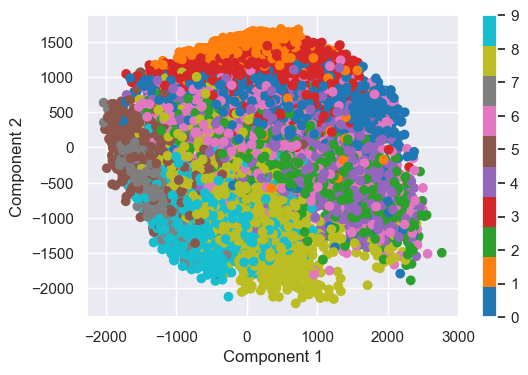

In [21]:
import seaborn as sns; sns.set()
plt.figure(dpi = 100) #dpi changes the size of the figure
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_test,cmap=plt.cm.get_cmap('tab10', 10)) #x-axis is the 1st column y-axis is the 2nd column
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()

### Scikit-Learn

Here, we'll be using both a supervised and an unsupervised model courtesy of the Scikit-Learn package. For the supervised model, we'll be using the K Nearest Neighbors classification model and for the unsupervised model, we'll be using the K-means model.

#### K Nearest Neighbors

If all of your friends jumped off a bridge would you do it too? In this case, you should! That is, if you are a data sample and your friends are your neighbors. The general idea here is that given a training dataset, you can take a new data sample and look at the $k$ samples that are most similar to your new data sample. Depending on the label that these $k$ samples belong to, your new sample will be a assigned (predicted) a label based on majority.

Here, the most important parameter is $k \leq n$ where $n$ is the amount of data samples. This decides **how many** near data samples should be considered. It's a general rule that a high value of $k$ will result in a less complex model with high bias and low variance and a low value of $k$ will result in a more complex model with low bias and high variance. This makes sense because say for example we let $k=n$. Then we would simply get the same label for **any** new data sample (a very simple model). On the other hand, if we let $k=1$ then the label prediction for each new sample will only depend on the label given to the most similar data sample.

This model trains by maximizing a probability function. When analyzing a new data sample, it finds the "probability" that the sample belongs to a certain class ($1,2,...,l$) for $l$ classes by finding the proportion of the $k$ neighboring data samples that actually do belong to that class. This can be seen mathematically:

$$ P(y=j|x) = \frac{1}{k}\sum_{i=1}^k1\{y^{(i)} = j\} $$

where $x$ is the new data sample, $j = 1,2,\dots,l$ represents the class being considered, and $y$ represents the true label belonging to our data sample $x$. Finally, the model assigns the data sample with the label that has the highest proportion.

In [22]:
import sklearn.neighbors

KNN = sklearn.neighbors.KNeighborsClassifier()
KNN.fit(X_train,y_train)
KNN.score(X_test,y_test)

0.8589

As you can see, this model predicted the correct label 85.89% of the time. This is slightly better than our logistic regression model which returned a score of 83.02%.

#### K-means

In this unsupervised learning model, the goal is to take a dataset containing $n$ samples and organize them into $k$ different clusters depending on the similarities based on the samples. Let each cluster be named $S_i$ where $i= 1,2,\dots k$. In our case, we have 10 different labels/classes so we set the most important parameter, n_clusters, equal to 10 in hope that the model will correctly place data samples with the same label into clusters.

How does this model decide to organize the clusters? Well by training the model. This model trains by using the loss function $L(x)$:

$$L(x) = \sum_{i=1}^k\sum_{x\in S_i} ||x-\mu_i||^2$$

where $\mu_i$ is the mean of cluster $S_i$. The model trains by inputing each datasample into the cluster that will result in the minimum value of our loss function $L$

In [23]:
import sklearn.cluster

Kmean = sklearn.cluster.KMeans(n_clusters = 10,n_jobs = -1) #n_jobs is set to equal -1 to make computation faster
Kmean.fit(X_test)
Kmean_trans = Kmean.transform(X_test)

/Users/Angel/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


### cuML

For this task we decide to try out the cuML package. Since the Scikit-Learn package is incompatible with GPU processors, cuML is the replacement when using GPU. That being said, the syntax style of this package is almost exactly the same. The following code was run on Kaggle using GPU:

In [7]:
import numpy as np
import pandas as pd
folder_dir = '../input/fashionmnist/'
#folder_dir = './'
data_train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
data_test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')
X_train = pd.DataFrame.to_numpy(data_train.iloc[:,1:])
y_train = pd.DataFrame.to_numpy(data_train['label'])
X_test = pd.DataFrame.to_numpy(data_test.iloc[:,1:])
y_test = pd.DataFrame.to_numpy(data_test['label'])

In [8]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [9]:
!nvidia-smi

Wed Mar 17 21:01:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |    629MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
%%time
import cuml
from cuml import LogisticRegression
clf_cuml = LogisticRegression()
clf_cuml.fit(X_train,y_train)
clf_cuml.score(X_test,y_test)

[E] [21:01:41.865866] L-BFGS line search failed
CPU times: user 2.92 s, sys: 15.9 ms, total: 2.94 s
Wall time: 2.93 s


0.8482000231742859

In [11]:
%%time
from sklearn.linear_model import LogisticRegression
clf_sk = LogisticRegression()
clf_sk.fit(X_train,y_train)
clf_sk.score(X_test,y_test)

CPU times: user 1min 45s, sys: 146 ms, total: 1min 45s
Wall time: 1min 45s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8544

Clearly, this model is MUCH faster than our logistic regression model with a run time of 2.93 seconds compared to 1 hour and 28 seconds. However, this model is only slightly more accurate as we recieve 84.82% accuracy here compared to 83.02%. 

Also this model is faster than the Scikit-Learn logistic regression model that has a run time of 1 minute and 45 seconds, but is slightly less accurate as the Scikit-Learn model has 85.44% accuracy.

## Conclusion
With that, we have reached the end of the notebook. As you can see, each model has their own purpose and each has their own pros and cons.